<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

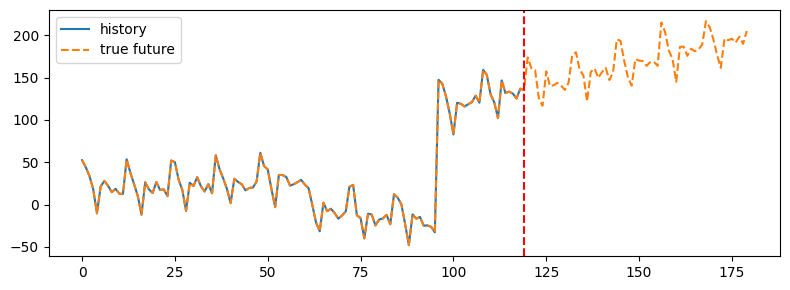

In [1]:
# ==========================================================
# 1. Generate Synthetic Time Series (History + Future Ground Truth)
# ==========================================================

import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (5*12)] = 0.2
    slope[(time >= (5*12)) & (time < (8*12))] = -0.4
    slope[time >= (8*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

# 10 years history
time_history = np.arange(10*12, dtype=np.float32)
ts_history = baseline + trend(time=time_history) \
    + seasonality(time=time_history, period=period, amplitude=amplitude)
ts_history += noise(time=time_history)
ts_history = ts_history.astype(np.float32)

# 15 years total (future only for comparison)
time_full = np.arange(15*12, dtype=np.float32)
ts_full = baseline + trend(time=time_full) \
    + seasonality(time=time_full, period=period, amplitude=amplitude)
ts_full += noise(time=time_full)
ts_full = ts_full.astype(np.float32)

# Plot
plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_full, y=ts_full, label='true future', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [2]:
# ==========================================================
# 2. Dataset
# ==========================================================

from sklearn import preprocessing
import torch

class Seq2SeqDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len=24, tgt_len=12):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).unsqueeze(dim=-1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.indices = list(range(len(ts) - (src_len + tgt_len) + 1))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        src = self.ts[i : i+self.src_len] # (24, 1)
        tgt = self.ts[i+self.src_len : i+self.src_len+self.tgt_len] # (12, 1)

        # temporal embeddings
        month_src = np.arange(start=i, stop=i+self.src_len)%12
        month_src = torch.tensor(data=month_src, dtype=torch.long)
        month_tgt = np.arange(start=i+self.src_len, stop=i+self.src_len+self.tgt_len)%12
        month_tgt = torch.tensor(data=month_tgt, dtype=torch.long)

        timeidx_src = np.arange(start=i, stop=i+self.src_len)
        timeidx_src = torch.tensor(data=timeidx_src, dtype=torch.long)
        timeidx_tgt = np.arange(start=i+self.src_len, stop=i+self.src_len+self.tgt_len)
        timeidx_tgt = torch.tensor(data=timeidx_tgt, dtype=torch.long)
        
        return src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt

# Scale and build dataset
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
ts_scaled = scaler.fit_transform(X=ts_history.reshape(-1, 1)).flatten()
src_len, tgt_len = 24, 12
ds_train = Seq2SeqDataset(ts=ts_scaled, src_len=src_len, tgt_len=tgt_len)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16, shuffle=True)
dl_val = torch.utils.data.DataLoader(dataset=ds_train, batch_size=16, shuffle=False)

src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = next(iter(dl_val))
print(src.shape, tgt.shape, month_src.shape, timeidx_tgt.shape)

torch.Size([16, 24, 1]) torch.Size([16, 12, 1]) torch.Size([16, 24]) torch.Size([16, 12])


In [3]:
# ==========================================================
# 3. Transformer Forecast Model
# ==========================================================

import torch

class TransformerForecast(torch.nn.Module):
    def __init__(self, in_dim=1, d_model=64, src_len=24, tgt_len=12):
        super().__init__()
        
        # Input projection
        self.input_proj = torch.nn.Linear(in_features=in_dim, out_features=d_model)
        
        # Temporal embeddings
        self.month_emb = torch.nn.Embedding(num_embeddings=12, embedding_dim=8)
        self.timeidx_emb = torch.nn.Embedding(num_embeddings=1000, embedding_dim=8)
        self.time_proj = torch.nn.Linear(in_features=(8+8), out_features=d_model)

        # Positional encoding (fixed)
        self.register_buffer('pos_src', torch.randn(1, src_len, d_model) * 0.01)
        self.register_buffer('pos_tgt', torch.randn(1, tgt_len, d_model) * 0.01)

        # Transformer layers
        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=4,
            batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=2)

        decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model, nhead=4,
            batch_first=True)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer=decoder_layer, num_layers=2)

        # Output projection
        self.output_proj = torch.nn.Linear(in_features=d_model, out_features=in_dim)

    def forward(self, src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt):
        # ---- Encoder -----------------------------------------------------
        src = self.input_proj(src)
        
        time_src = torch.cat(tensors=[
            self.month_emb(month_src),
            self.timeidx_emb(timeidx_src)
        ], dim=-1)
        time_src = self.time_proj(time_src)
        
        src = src + time_src + self.pos_src
        memory = self.encoder(src) # (B, src_len, d_model)

        # ---- Decoder -----------------------------------------------------
        tgt = self.input_proj(tgt)
        
        time_tgt = torch.cat(tensors=[
            self.month_emb(month_tgt),
            self.timeidx_emb(timeidx_tgt)
        ], dim=-1)
        time_tgt = self.time_proj(time_tgt)
        
        tgt = tgt + time_tgt + self.pos_tgt

        tgt_mask =  torch.nn.Transformer.generate_square_subsequent_mask(sz=tgt.size(1))\
            .to(src.device)
        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
        return self.output_proj(out)

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast(in_dim=1, d_model=64, src_len=24, tgt_len=12).to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

out = model(src=src, tgt=tgt, month_src=month_src, month_tgt=month_tgt,
    timeidx_src=timeidx_src, timeidx_tgt=timeidx_tgt)
print(out.shape)

Total model parameters: 1167521
torch.Size([16, 12, 1])


Training duration: 168.23s


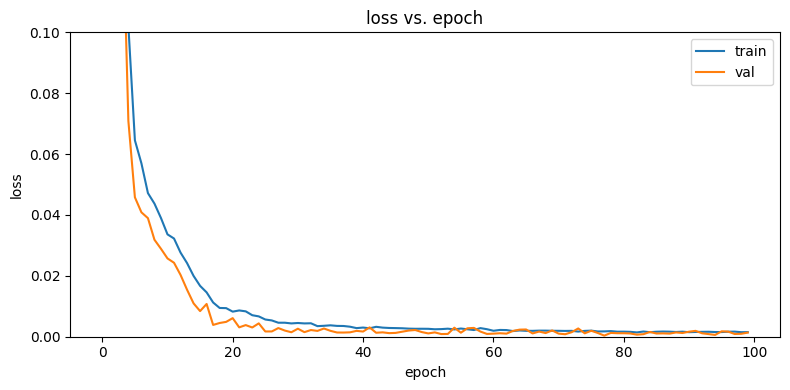

In [4]:
# ==========================================================
# 4. Training & Validation (No Teacher Forcing in Validation)
# ==========================================================

import torch
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl_train, criterion, optimizer):
    model.train()
    losses = []
    for batch in dl_train:
        src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = batch
        src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = \
            src.to(device), tgt.to(device), month_src.to(device), month_tgt.to(device),\
            timeidx_src.to(device), timeidx_tgt.to(device)

        tgt_in = torch.cat(tensors=[src[:, -1:], tgt[:, :-1]], dim=1)
        
        out = model(src=src, tgt=tgt_in, month_src=month_src, month_tgt=month_tgt,
            timeidx_src=timeidx_src, timeidx_tgt=timeidx_tgt)
        
        loss = criterion(input=out, target=tgt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# ---- Strict autoregressive decode for validation ----
@torch.no_grad()
def autoregressive_decode(model, src, month_src, timeidx_scr, start_idx, horizon=12):
    model.eval()
    B = src.size(0)

    # decoder input starts with last point
    tgt = torch.zeros(B, 1, 1, dtype=torch.float32, device=src.device)
    tgt[:, 0, 0] = src[:, -1, 0]

    preds = []
    for t in range(horizon):
        # Temporal embeddings for step t
        month_tgt = torch.tensor(data=[(start_idx + t) % 12], device=src.device)\
            .repeat(B).unsqueeze(dim=1)
        timeidx_tgt = torch.tensor(data=[start_idx + t], device=src.device)\
            .repeat(B).unsqueeze(dim=1)
        out = model(src=src, tgt=tgt, month_src=month_src, month_tgt=month_tgt,
            timeidx_src=timeidx_src, timeidx_tgt=timeidx_tgt)
        next_val = out[:, -1, 0] # shape (B,)
        preds.append(next_val)
        
        # append predicted step to tgt
        next_val = next_val.unsqueeze(dim=1).unsqueeze(dim=2)
        tgt = torch.cat([tgt, next_val], dim=1)
    preds = torch.stack(preds, dim=1) # (B, horizon)
    return preds

@torch.no_grad()
def test_step(model, dl_val, criterion):
    model.eval()
    losses = []
    for batch in dl_val:
        src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = batch
        src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = \
            src.to(device), tgt.to(device), month_src.to(device), month_tgt.to(device),\
            timeidx_src.to(device), timeidx_tgt.to(device)

        start_idx = timeidx_tgt[:, 0].to(device)

        out = autoregressive_decode(
            model=model, src=src, month_src=month_src, timeidx_src=timeidx_src,
            start_idx=start_idx[0].item(), horizon=tgt.size(1)
        )
        
        loss = criterion(input=out.unsqueeze(dim=-1), target=tgt)
        losses.append(loss.item())
    return np.mean(losses)

def training(model, dl_train, dl_val, model_path, max_epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
        factor=0.9, patience=5)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(max_epochs):
        train_loss = train_step(model, dl_train, criterion, optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model, dl_val, criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(obj=model.state_dict(), f=model_path)

    return model, history

start_time = time.time()
os.makedirs('models', exist_ok=True)
model_path = 'models/best_model.pth'
model, history = training(model, dl_train, dl_val, model_path, max_epochs=100)
print("Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

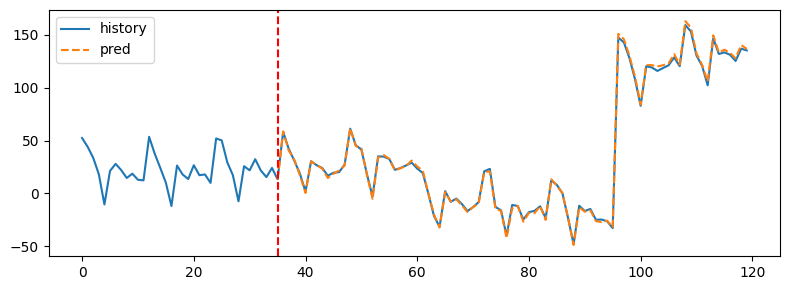

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast(in_dim=1, d_model=64, src_len=24, tgt_len=12).to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

ts_pred = []
for batch in dl_val:
    src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = batch
    src, tgt, month_src, month_tgt, timeidx_src, timeidx_tgt = \
        src.to(device), tgt.to(device), month_src.to(device), month_tgt.to(device),\
        timeidx_src.to(device), timeidx_tgt.to(device)
    
    tgt_in = torch.cat(tensors=[
        src[:, -1:, :],
        tgt[:, :-1, :] + 0.01*torch.randn_like(tgt[:, :-1, :])
    ], dim=1)

    model.eval()
    with torch.no_grad():
        out = model(src=src, tgt=tgt_in, month_src=month_src, month_tgt=month_tgt,
            timeidx_src=timeidx_src, timeidx_tgt=timeidx_tgt)
        ts_pred.append(out[:, -1])

ts_pred = torch.cat(tensors=ts_pred, dim=0)
ts_pred = scaler.inverse_transform(X=ts_pred).squeeze()
time_pred = time_history[-len(ts_pred):]

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=time_pred, y=ts_pred, label='pred', linestyle='--')
plt.axvline(x=time_pred[0], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

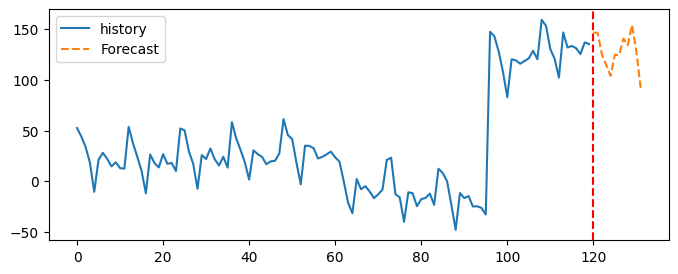

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerForecast(in_dim=1, d_model=64, src_len=24, tgt_len=12).to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

# for i in range(1, 60//12):
start_idx = len(ts_history) - src_len
src = scaler.transform(X=ts_history[-src_len:].reshape(-1, 1)).flatten()
src = torch.tensor(data=src, dtype=torch.float32).view(1, src_len, 1).to(device)

month_src = np.arange(start=start_idx, stop=start_idx+src_len)%12
month_src = torch.tensor(data=month_src, dtype=torch.long)\
    .unsqueeze(dim=0).to(device)
month_tgt = np.arange(start=start_idx+src_len, stop=start_idx+src_len+tgt_len)%12
month_tgt = torch.tensor(data=month_tgt, dtype=torch.long)\
    .unsqueeze(dim=0).to(device)

timeidx_src = np.arange(start=start_idx, stop=start_idx+src_len)
timeidx_src = torch.tensor(data=timeidx_src, dtype=torch.long)\
    .unsqueeze(dim=0).to(device)
timeidx_tgt = np.arange(start=start_idx+src_len, stop=start_idx+src_len+tgt_len)
timeidx_tgt = torch.tensor(data=timeidx_tgt, dtype=torch.long)\
    .unsqueeze(dim=0).to(device)

tgt_in = torch.zeros(1, tgt_len, 1).to(device)
tgt_in[0, 0] = src[0, -1]

ts_forecast = []
model.eval()
with torch.no_grad():
        for t in range(1, tgt_len):
            out = model(src=src, tgt=tgt_in, month_src=month_src, month_tgt=month_tgt,
                timeidx_src=timeidx_src, timeidx_tgt=timeidx_tgt)
            ts_forecast.append(out[0, t-1])
            tgt_in[0, t] = out[0, t-1]
        ts_forecast.append(out[0, -1])
ts_forecast = torch.cat(tensors=ts_forecast, dim=0)
ts_forecast = scaler.inverse_transform(X=ts_forecast.unsqueeze(dim=-1)).flatten()

plt.figure(figsize=(8 ,3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=np.arange(len(ts_history), len(ts_history)+tgt_len),
    y=ts_forecast, label='Forecast', linestyle='--')
plt.axvline(x=len(ts_history), color='red', linestyle='--')
plt.legend()
plt.show()

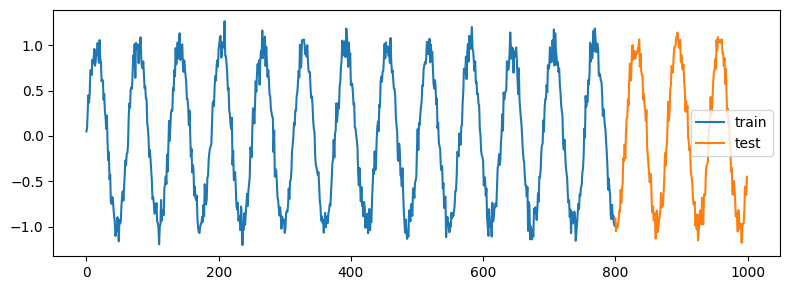

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ts(num_steps, interval=0.1):
    np.random.seed(seed=42)
    t = np.linspace(start=0, stop=num_steps * interval, num=num_steps)
    data = np.sin(t) + np.random.normal(loc=0, scale=0.1, size=t.shape)
    return data

ts = generate_ts(num_steps=1000)
ts_train, ts_test = ts[:-int(len(ts)*.2)], ts[-int(len(ts)*.2):]

plt.figure(figsize=(8, 3))
plt.plot(range(0, len(ts_train)), ts_train, label='train')
plt.plot(range(len(ts_train), len(ts)), ts_test, label='test')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch

def create_seqs(ts, in_window=24, out_window=12):
    seqs = []
    for i in range(len(ts) - (in_window + out_window) + 1):
        src = ts[i : i + in_window]
        tgt = ts[i + in_window -1 : i + in_window + out_window -1]
        tgt_y = ts[i + in_window : i + in_window + out_window]
        seqs.append((src, tgt, tgt_y))
    return seqs

seqs_train = create_seqs(ts=ts_train)
seqs_test = create_seqs(ts=ts_test)

class SeqsDataset(torch.utils.data.Dataset):
    def __init__(self, seqs):
        super().__init__()
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        src, tgt, tgt_y = self.seqs[idx]
        src = torch.tensor(data=src, dtype=torch.float32).view(-1, 1)
        tgt = torch.tensor(data=tgt, dtype=torch.float32).view(-1, 1)
        tgt_y = torch.tensor(data=tgt_y, dtype=torch.float32).view(-1, 1)
        return src, tgt, tgt_y

dl_train = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_train),
    batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset=SeqsDataset(seqs=seqs_test),
    batch_size=32, shuffle=False)
len(dl_train), len(dl_test)

(24, 6)

In [ ]:
import torch
import numpy as np

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        position = torch.arange(end=max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float()
            * (-np.log(10000.0) / d_model))
        pe = torch.zeros(size=(1, max_len, d_model))
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerWithPE(torch.nn.Module):
    def __init__(self, in_dim, out_dim, d_model, nhead, num_layers):
        super().__init__()
        self.encoder_embedding = torch.nn.Linear(in_features=in_dim,
            out_features=d_model)
        self.decoder_embedding = torch.nn.Linear(in_features=out_dim,
            out_features=d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model)

        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
            num_encoder_layers=num_layers, num_decoder_layers=num_layers,
            batch_first=True)

        self.output_layer = torch.nn.Linear(in_features=d_model,
            out_features=out_dim)

    def forward(self, src, tgt):
        src = self.encoder_embedding(src)
        src = self.positional_encoding(src)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.shape[1])

        tgt = self.decoder_embedding(tgt)
        tgt = self.positional_encoding(tgt)

        pred = self.transformer(src=src, tgt=tgt, tgt_mask=tgt_mask)
        pred = self.output_layer(pred)
        return pred

    def infer(self, src, tgt_len):
        output = torch.zeros(size=(src.shape[0], tgt_len + 1, src.shape[2]))\
            .to(src.device)
        output[:, 0] = src[:, -1]
        for i in range(tgt_len):
            output[:, i + 1] = model.forward(src=src, tgt=output)[:, i]
        return output[:, 1:]

torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerWithPE(in_dim=1, out_dim=1,
    d_model=128, nhead=8, num_layers=2
).to(device)

Training duration: 778.44s


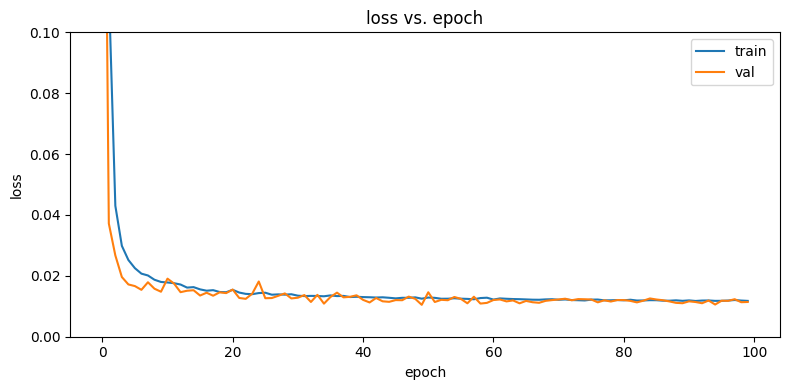

In [ ]:
import numpy as np
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def train_step(model, dl, criterion, optimizer):
    model.train()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl, criterion):
    model.eval()
    losses = []
    for src, tgt, tgt_y in dl:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model(src=src, tgt=tgt)
        loss = criterion(input=y_pred, target=tgt_y)
        losses.append(loss.item())
    return np.mean(losses)

def train_model(model, dl_train, dl_val, epochs):
    torch.manual_seed(seed=42)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
        mode='min', factor=0.9, patience=3)

    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        train_loss = train_step(model=model, dl=dl_train, criterion=criterion,
            optimizer=optimizer)
        history['train_loss'].append(train_loss)
        val_loss = test_step(model=model, dl=dl_val, criterion=criterion)
        history['val_loss'].append(val_loss)
        scheduler.step(val_loss)
    return model, history

start_time = time.time()
model, history = train_model(model=model, dl_train=dl_train, dl_val=dl_test,
    epochs=100)
print(f"Training duration: %.2fs"%(time.time() - start_time))

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val')
    plt.legend(loc='best')
    plt.title(label=f'loss vs. epoch')
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss')
    plt.ylim(bottom=0, top=0.1)
    plt.tight_layout()
    plt.show()

plot_history(history=history)

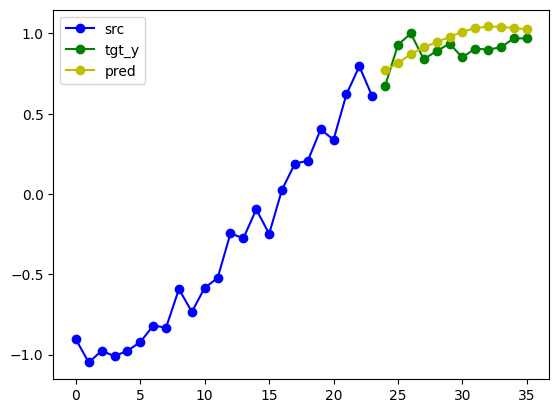

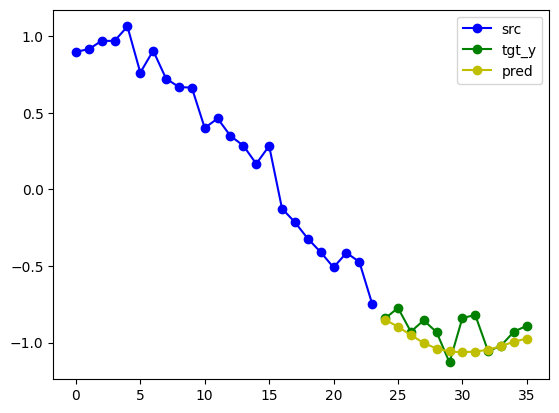

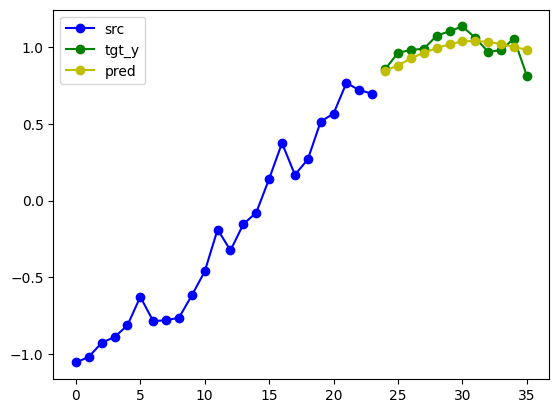

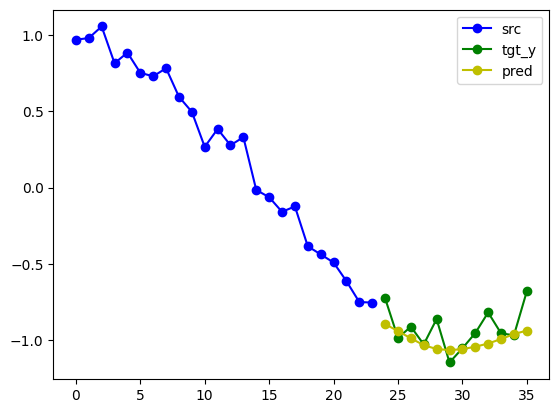

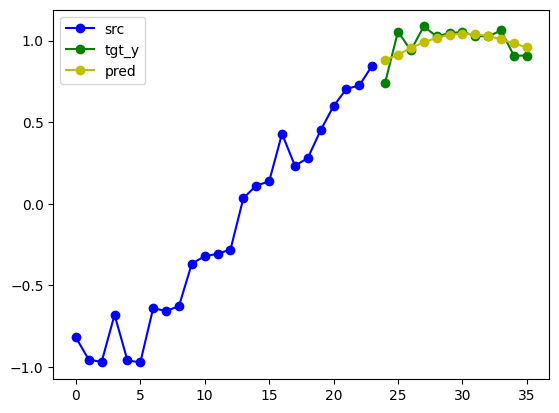

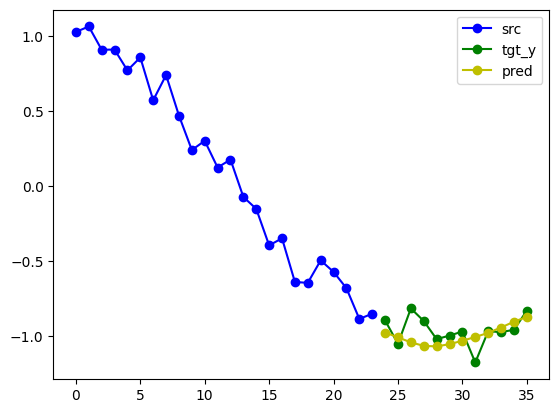

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for src, tgt, tgt_y in dl_test:
        src, tgt, tgt_y = src.to(device), tgt.to(device), tgt_y.to(device)
        y_pred = model.infer(src=src, tgt_len=tgt_y.shape[1])

        x = np.arange(src.shape[1] + tgt_y.shape[1])
        src_len = src.shape[1]
        idx = 0
        plt.plot(x[:src_len], src[idx].cpu().detach(), "bo-", label="src")
        plt.plot(x[src_len:], tgt_y[idx].cpu().detach(), "go-", label="tgt_y")
        plt.plot(x[src_len:], y_pred[idx].cpu().detach(), "yo-", label="pred")

        plt.legend()
        plt.show()
        plt.clf()